In [28]:
import os
import pickle as pkl
from urllib.request import urlretrieve

import numpy as np
import torch
from torch.utils.data import Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import timesynth as ts

#dimensions = 1
#T = 100000
# reference https://github.com/TimeSynth/TimeSynth/blob/master/TimeSynthExamples.ipynb
#time_sampler = ts.TimeSampler(stop_time=1000)

#irregular_time_samples = time_sampler.sample_irregular_time(num_points=T, keep_percentage=50)
#regular_time_samples = time_sampler.sample_regular_time(num_points=T)
#sinusoid = ts.signals.Sinusoidal(frequency=0.25)
#white_noise = ts.noise.GaussianNoise(std=0.3)

#timeseries = ts.TimeSeries(sinusoid, noise_generator=white_noise)

#samples = timeseries.sample(regular_time_samples)[0]
#samples = [[x] for x in samples]
# samples should be [samples, dimensions]

#continuous autoregressive
#car = ts.signals.CAR(ar_param=0.9, sigma=0.01)
#car_series = ts.TimeSeries(signal_generator=car)
#samples = car_series.sample(regular_time_samples)[0]



In [29]:
from torch.utils.data import DataLoader

class SyntheticDataset(Dataset):
    """Setup data for the time series data"""

    def __init__(self, data, dimensions, window_size = 100, device='cpu', transform=None):
        # when batch_len = 1 it means that it takes one time-step at a time
        self.device = device
        self.data = torch.tensor(data, dtype=torch.float).view(-1, dimensions)
        # the length of the time series we look at for each weight update
        self.window_size = window_size
        #print(self.data)
        self.transform = transform

    def __len__(self):
        # this is the number of time serieses that are created when using a set
        # window size. If window size = len of the time series, then I have 1 time series
        # available for training
        return int(self.data.shape[0] - self.window_size) + 1
        #return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx: idx + self.window_size]
        if self.transform:
            sample = self.transform(sample)
        return sample.to(self.device)

def generate_timeseries(signals, T = 10000, noise_std = 0.01):
    # used to define the time scale
    time_sampler = ts.TimeSampler(stop_time=1000)
    # create the time samples
    regular_time_samples = time_sampler.sample_regular_time(num_points=T)
    # define the standard gaussian white noise to add
    white_noise = ts.noise.GaussianNoise(std=noise_std)
    
    # the list of all the time serieses
    timeserieses = []
    for signal_type, params in signals:
        if signal_type == "sinusoid":
            sinusoid = ts.signals.Sinusoidal(**params)
            timeserieses.append(ts.TimeSeries(sinusoid, noise_generator=white_noise))
        if signal_type == "ar":
            ar_p = ts.signals.AutoRegressive(**params)
            timeserieses.append(ts.TimeSeries(signal_generator=ar_p))            
    
    # convert to numpy array and select only the signals
    output_samples = np.array([cur_timeseries.sample(regular_time_samples)[0] 
                                                for cur_timeseries in timeserieses])
    # transpose to allow [time x features]
    return output_samples.T

def insert_anomalies(timeseries_samples, p = 0.01, magnitude = 1):
    import random as rnd
    timeseries_samples_with_anomalies = np.zeros(timeseries_samples.shape)
    anomaly = magnitude*np.ones(timeseries_samples.shape[1])
    labels = []
    t = -1
    for sample in timeseries_samples:
        t += 1
        if rnd.random() < p:
            labels.append(1)
            if rnd.random() < 0.5:
                timeseries_samples_with_anomalies[t] = sample + anomaly
            else:
                timeseries_samples_with_anomalies[t] = sample - anomaly
            
        else:
            labels.append(0)
            timeseries_samples_with_anomalies[t] = sample

    return timeseries_samples_with_anomalies, labels

signals = [
    ("sinusoid", {"frequency":1.25}),
    ("sinusoid", {"frequency":1.5}),
    ("sinusoid", {"frequency":1.3})
]
train_timeseries = generate_timeseries(signals, T = 100)

#print(train_timeseries.shape)
train_timeseries_signals, train_timeseries_labels = insert_anomalies(train_timeseries, magnitude = 0)

batch_size = 5
features = len(signals)
train_dataset = SyntheticDataset(train_timeseries_signals, features, window_size = 10)
train_loader = DataLoader(train_dataset, batch_size = batch_size,  shuffle = True)


In [30]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as distributions

# x[batch_size, num_features]
# z[batch_size, latent_features]
class Standard_LSTM(nn.Module):
    def __init__(self, input_dimension, param_size, hidden_dim):
        super(Standard_LSTM, self).__init__()
        
        self.input_dimension = input_dimension
        self.hidden_dim = hidden_dim
        self.param_size = param_size
        self.lstm = nn.LSTM(input_dimension, hidden_dim)
        self.hidden2params = nn.Linear(hidden_dim, param_size*input_dimension)
    def forward(self, x):
        outputs = {}
        time_length = len(x)
        outputs["x_input"] = x
        
        x = x.permute(1,0,2)
#        x = x.view(time_length, self.batch_size, self.input_dimension)
        # lstm_out is the output of the last layer of hidden units [seq_len, batch, num_directions * hidden_size]
        # h is the hidden states at the last time step
        # c is the cell state at the last time step
        lstm_out, (h, c) = self.lstm(x)
        
        # linear wants [batch, seq_len, hidden_size]
        linear_in = lstm_out.permute(1,0,2)
        # take output of hidden layers at each time step h_t and run it through a fully connected layer
        params = self.hidden2params(linear_in)
        
        outputs["x_hat_params"] = params
        outputs["param_size"] = self.param_size
        return outputs
    
model = Standard_LSTM(features, 2, 16)

with torch.no_grad():
    inputs = torch.from_numpy(train_timeseries_signals[:-1]).float().unsqueeze(1)
    output_model = model(inputs)
    print(output_model["x_hat_params"].shape)

torch.Size([99, 1, 6])


In [31]:
def loss_function_normal(model_output):
    # unpack the required quantities
    x_true = model_output["x_input"]
    
    input_dimension = x_true.shape[2]
    
    if model_output["x_hat_params"].shape[2] != 2*input_dimension:
        raise ValueError("Wrong input dimensions or number of parameters in the output")
    
    mu, log_var = torch.chunk(model_output["x_hat_params"], 2, dim = 2)
    sigma = torch.exp(log_var / 2)

    seq_length = mu.shape[1]
    # iterate over each time step in the sequence to compute NLL and KL terms

    t = 0
    cov_matrix = torch.diag_embed(sigma[:, t, :])
    # define the distribution
    p = distributions.MultivariateNormal(mu[:, t, :], cov_matrix)
    log_prob = p.log_prob(x_true[:, t + 1, :])

    for t in range(1, seq_length - 1):
        #print(t)
        # construct (diagonal) covariance matrix for each time step based on
        # the estimated var from the model
        cov_matrix = torch.diag_embed(sigma[:, t, :])

        # define the distribution
        p = distributions.MultivariateNormal(mu[:, t, :], cov_matrix)
        
        log_prob += p.log_prob(x_true[:, t + 1, :])
        #print(x_true.shape)

    NLL = - torch.mean(log_prob, dim = 0) / seq_length 
    return NLL


Starting training
Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
[3.1693209472455477, 3.1190852240512243, 3.0718216519606742, 3.007659648594103, 2.922405067243074, 2.7864030160402, 2.603705130125347, 2.377292382089715, 2.126275144125286, 1.8769471708096956, 1.5918578913337307, 1.335735421431692, 1.1243367351983722, 0.9264135203863445, 0.7600152868973581, 0.6074599121746264, 0.45522535788385493, 0.32686428019874975, 0.19445570126960152, 0.07346305393270756, -0.04918792074252116, -0.17481085285544395, -0.27704672554605886, -0.3665659317844792, -0.468258493825009, -0.555113097554759, -0.629748639307524, -0.7267369126018725, -0.8345483447376051, -0.9062081826360602, -0.9600143652213248, -1.0636257999821712, -1.1513287832862453, -1.2180603742599487, -1.2908729126578884, -1.3609282782203274, -1.4260013605418957, -1.490752847571122, -1.5471482653366893, -1.6184147659100985, -1.6544874279122603, -1.729903967756974, -1.7545632563139264, -1.854

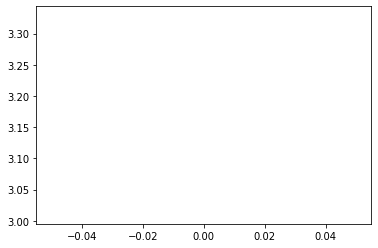

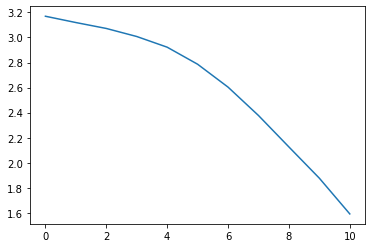

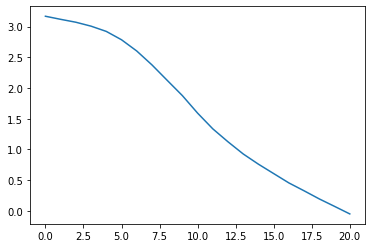

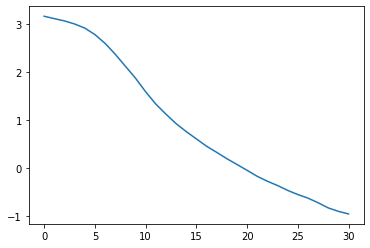

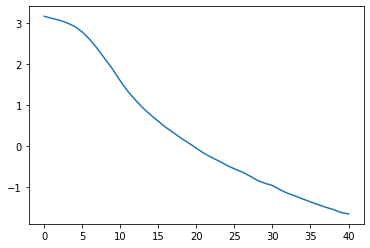

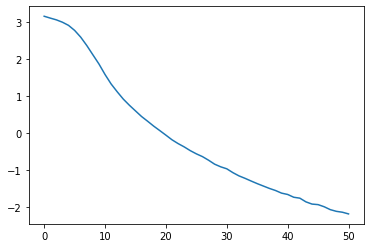

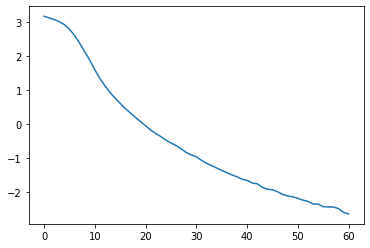

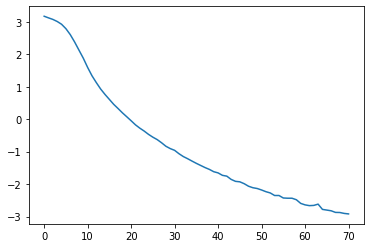

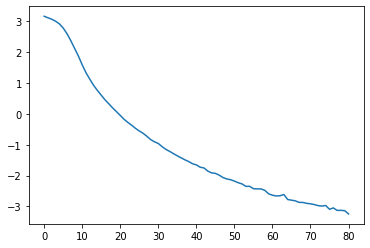

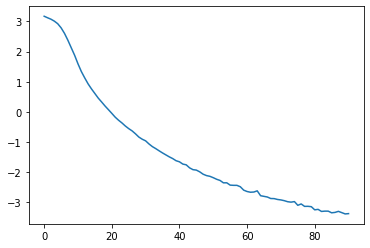

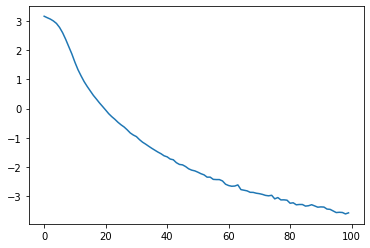

In [32]:
import matplotlib.pyplot as plt

seq_len = 50
cur_train_timeseries_signals = torch.from_numpy(train_timeseries_signals[:seq_len]).float().unsqueeze(1)

model = Standard_LSTM(features, 2, 16)
loss_function = loss_function_normal
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loss = []
print("Starting training")
model.train()
for epoch in range(100):
        if epoch % 10 == 0:
            print("Epoch: {}".format(epoch))
        batch_loss = []
        for batch_idx, x in enumerate(train_loader):
            #if (batch_idx % 10 == 0):
            #    print("Batch idx: ", batch_idx)
            model.zero_grad()
            input = x
            #targets = torch.from_numpy(train_timeseries_signals[1:]).float().unsqueeze(1)
    
            output_model = model(input)
    
            loss = loss_function(output_model)
            batch_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            
            # loss on this batch
        train_loss.append(np.mean(batch_loss))
        if epoch % 10 == 0:
            plt.close("all")
            plt.plot(range(len(train_loss)), train_loss)
            plt.show()

print(train_loss)
plt.plot(range(len(train_loss)), train_loss)
plt.show()  

(50, 3)


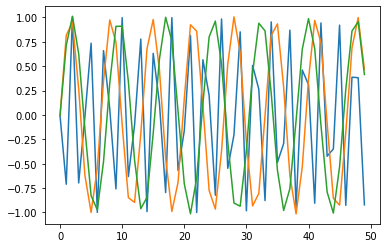

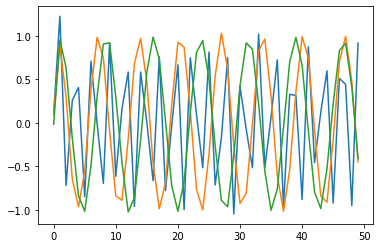

In [33]:
n_time_sample = 50
plt.plot(range((n_time_sample)), train_timeseries_signals[:n_time_sample])
model.eval()
with torch.no_grad():
    predicted = []
    x = torch.from_numpy(train_timeseries_signals[:n_time_sample]).float()
    x = x.unsqueeze(0)
    model_output = model(x)
    
    # unpack the required quantities
    x_true = model_output["x_input"]
    #permute to have [batch, seq_len, input_dimension]
    x_true = x_true.permute(1,0,2)
    
    input_dimension = x_true.shape[2]
    
    if model_output["x_hat_params"].shape[2] != 2*input_dimension:
        raise ValueError("Wrong input dimensions or number of parameters in the output")
    
    mu, log_var = torch.chunk(model_output["x_hat_params"], 2, dim = -1)
    sigma = torch.exp(log_var / 2)
    #print(next)
    #print( torch.exp(log_var/2))
    #cov_matrix = torch.diag_embed(sigma[:, t, :])
    # define the distribution
    #p = distributions.MultivariateNormal(mu[:, t, :], cov_matrix)
    #log_prob = p.log_prob(x_true[:, t + 1, :])
    #print(train_timeseries_signals[1:n_time_sample+1])
    #print(m.log_prob(torch.from_numpy(train_timeseries_signals[1:n_time_sample+1]).float()))
    predicted = mu.squeeze().numpy()
    plt.figure()
    plt.plot(range(n_time_sample), predicted[:n_time_sample])
print(predicted[:n_time_sample].shape)
difference = train_timeseries_signals[1:n_time_sample+1]-predicted

In [34]:
np.mean(np.abs(difference))


0.06966028374137903